In [1]:
import os 
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential 
from keras.layers import Activation, Dense, Flatten
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
img_size = 64
frame_len = 15
NUM_CLASSES = 10

In [3]:
label_data = pd.read_csv("/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt", sep=' ', header=None)
label_data.columns=['index', 'labels']
label_data = label_data.drop(['index'], axis=1)
label_data.head()

,labels
0,ApplyEyeMakeup
1,ApplyLipstick
2,Archery
3,BabyCrawling
4,BalanceBeam


In [4]:
def get_ucf101_paths():
    base_path = "/kaggle/input/ucf101/UCF101/UCF-101"
    paths = []
    for label in label_data.labels.values:
        paths.append(os.path.join(base_path, label))
    return paths

path = get_ucf101_paths()
print(path[3])

/kaggle/input/ucf101/UCF101/UCF-101/BabyCrawling


In [5]:
def video_Frames(clip_path):
    video = cv2.VideoCapture(clip_path)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    for count in range(frame_len):
        video.set(cv2.CAP_PROP_POS_FRAMES,count*max(int(frame_count/frame_len),1))
        flag, frame = video.read()
        if not flag:
            break
        frame = cv2.resize(frame,(img_size,img_size))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
        #normalizing the pixels between 0 and 1
        frame = frame/255.0
        yield frame 
    video.release()
def load_video(dataset):
    imgs = []
    labels = []
    idx = 0
    for path_names in dataset:
        for folder in tqdm(os.listdir(path_names)):
            folder_path = os.path.join(path_names,folder)
            frames_generator = video_Frames(folder_path)
            frames_array = np.array(list(frames_generator))
            imgs.append(frames_array)
            labels.append(idx)
        idx+=1
    return np.array(imgs), labels

In [6]:
imgs_total, labels_total = load_video(path[:NUM_CLASSES])

100%|██████████| 160/160 [00:08<00:00, 18.57it/s]


In [7]:
labels_total[940:945]

[6, 6, 6, 6, 6]

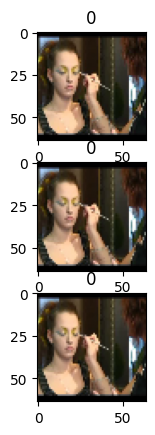

In [8]:
count = 0
fig, axs = plt.subplots(3)
while count < 3:
    img = imgs_total[90][count]
    axs[count].imshow(img)
    axs[count].set_title(labels_total[90])
    count += 1

In [9]:
from keras.utils import to_categorical

targets = to_categorical(labels_total)
targets[100:105]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [10]:
batch_size = 16
X_train_val,X_test,Y_train_val,Y_test = train_test_split(imgs_total,targets,test_size = 0.3,random_state = 42,shuffle = True)
X_train,X_val,Y_train,Y_val = train_test_split(X_train_val,Y_train_val,test_size = 0.3,random_state = 42,shuffle = True)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()

In [11]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(None, 15, 64, 64, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [12]:
def Res_block(filters, layer, isStride = False):
    stride_val = 1
    if isStride == True :
        stride_val = 2
    cx = tf.keras.layers.Conv3D(filters,(1,3,3),strides=stride_val,padding='same')(layer)
    cx = tf.keras.layers.BatchNormalization()(cx)
    cx = tf.keras.layers.Activation('relu')(cx)
    cy = tf.keras.layers.Conv3D(filters,(3,1,1),padding='same')(cx)
    cy = tf.keras.layers.BatchNormalization()(cy)
    cy = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.3))(cy)
    return cy

In [13]:
def RESNET_model(start_filters = 64):
    #1
    inputs = tf.keras.layers.Input((15,64,64,3))
    c1 = tf.keras.layers.Conv3D(start_filters,(3,3,3),strides=2,padding='same')(inputs)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Activation('relu')(c1)
    
    #2
    c2 = Res_block(start_filters,c1)
    c2_concat = tf.keras.layers.Add()([c1,c2])
    c2_concat = tf.keras.layers.Activation('relu')(c2_concat)
    
    #3
    c5 = Res_block(start_filters*2,c2_concat,isStride = True)
    d1 = tf.keras.layers.Conv3D(start_filters*2,(1,1,1),strides=2,padding='same')(c2_concat)
    d1 = tf.keras.layers.BatchNormalization()(d1)
    c5_concat = tf.keras.layers.Add()([d1,c5])
    c5_concat = tf.keras.layers.Activation('relu')(c5_concat)
    
    #4
    c9 = Res_block(start_filters*4,c5_concat,isStride = True)
    d2 = tf.keras.layers.Conv3D(start_filters*4,(1,1,1),strides=2,padding='same')(c5_concat)
    d2 = tf.keras.layers.BatchNormalization()(d2)
    c9_concat = tf.keras.layers.Add()([d2,c9])
    c9_concat = tf.keras.layers.Activation('relu')(c9_concat)
    
    #5
    c15 = Res_block(start_filters*8,c9_concat,isStride = True)
    d3 = tf.keras.layers.Conv3D(start_filters*8,(1,1,1),strides=2,padding='same')(c9_concat)
    d3 = tf.keras.layers.BatchNormalization()(d3)
    c15_concat = tf.keras.layers.Add()([d3,c15])
    c15_concat = tf.keras.layers.Activation('relu')(c15_concat)
    
    
    G1 = tf.keras.layers.Flatten()(c15_concat)
    D1 = tf.keras.layers.Dense(2048,kernel_regularizer=tf.keras.regularizers.L2(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01))(G1)
    outputs = tf.keras.layers.Dense(10, activation = 'softmax')(D1)
    ResNet_model = tf.keras.Model(inputs=[inputs],outputs=[outputs])
    
    return ResNet_model


model = RESNET_model(16)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 15, 64, 64, 3)]      0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 8, 32, 32, 16)        1312      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 8, 32, 32, 16)        64        ['conv3d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 8, 32, 32, 16)        0         ['batch_normalization[0][0

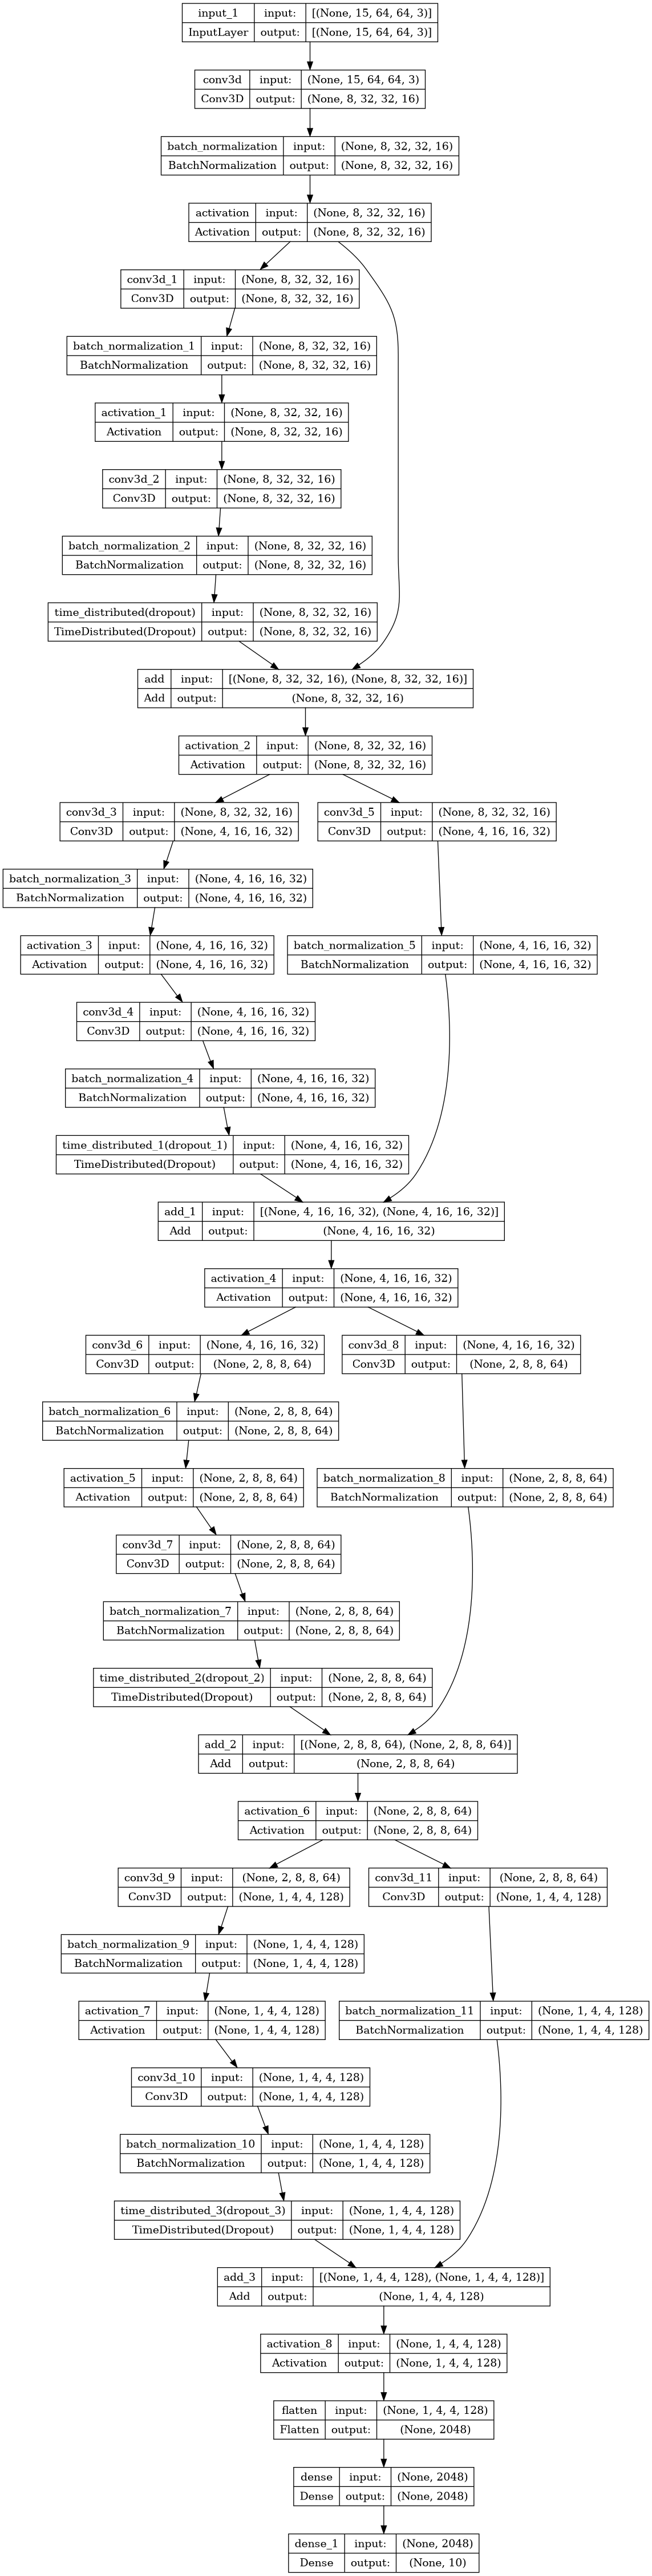

In [14]:
plot_model(model, to_file='RESNET.png', show_shapes=True, show_layer_names=True)

In [15]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('activity_recognition.h5',verbose=1,save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,min_lr=1e-6,patience=10,verbose=1),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=30,verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(train_ds,validation_data=val_ds,epochs=100,callbacks=callbacks)

Epoch 1/100
40/42 [===========================>..] - ETA: 0s - loss: 33.1164 - accuracy: 0.2016
Epoch 1: val_loss improved from inf to 19.58072, saving model to activity_recognition.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - 17s 56ms/step - loss: 32.6741 - accuracy: 0.1979 - val_loss: 19.5807 - val_accuracy: 0.2664 - lr: 0.0010
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 20.1035 - accuracy: 0.3527
Epoch 2: val_loss improved from 19.58072 to 16.14571, saving model to activity_recognition.h5
42/42 [==============================] - 1s 34ms/step - loss: 20.1035 - accuracy: 0.3527 - val_loss: 16.1457 - val_accuracy: 0.3010 - lr: 0.0010
Epoch 3/100
40/42 [===========================>..] - ETA: 0s - loss: 15.5587 - accuracy: 0.4656
Epoch 3: val_loss improved from 16.14571 to 12.90788, saving model to activity_recognition.h5
42/42 [==============================] - 1s 34ms/step - loss: 15.4761 - accuracy: 0.4583 - val_loss: 12.9079 - val_accuracy: 0.2042 - lr: 0.0010
Epoch 4/100
40/42 [===========================>..] - ETA: 0s - loss: 11.9178 - accuracy: 0.5094
Epoch 4: val_loss improved from 12.90788 to 10.01414, saving model to activity_recogniti

In [16]:
model.evaluate(test_ds)

26/26 [==============================] - 1s 16ms/step - loss: 0.5030 - accuracy: 0.8814


[0.502979576587677, 0.8813559412956238]

In [17]:
from keras.layers import BatchNormalization, ConvLSTM2D, MaxPooling3D, TimeDistributed, Flatten, Dense, Dropout, Conv2D

model1 = Sequential()

model1.add(BatchNormalization(momentum=0.8, input_shape=(15,64,64, 3)))
model1.add(ConvLSTM2D(filters = 8, kernel_size=(3,3), activation='tanh', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model1.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model1.add(TimeDistributed(Dropout(0.2)))

model1.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='tanh', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model1.add(BatchNormalization(momentum=0.8))
model1.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model1.add(TimeDistributed(Dropout(0.2)))

model1.add(ConvLSTM2D(filters = 32, kernel_size=(3,3), activation='tanh', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model1.add(BatchNormalization(momentum=0.8))
model1.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model1.add(TimeDistributed(Dropout(0.3)))

model1.add(Flatten())

model1.add(Dense(128,activation="relu"))
    
model1.add(Dense(10, activation='softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_12 (Ba  (None, 15, 64, 64, 3)     12        
 tchNormalization)                                               
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 15, 62, 62, 8)     3200      
                                                                 
 max_pooling3d (MaxPooling3  (None, 15, 31, 31, 8)     0         
 D)                                                              
                                                                 
 time_distributed_4 (TimeDi  (None, 15, 31, 31, 8)     0         
 stributed)                                                      
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 15, 29, 29, 16)    13888     
                                                        

In [18]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [19]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('activity_recognition2.h5',verbose=1,save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,min_lr=1e-6,patience=10,verbose=1),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=30,verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model1.fit(train_ds,validation_data=val_ds,epochs=100,callbacks=callbacks)

Epoch 1/100


2023-11-29 21:28:24.709809: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/conv_lstm2d/while/body/_1/sequential/conv_lstm2d/while/dropout_3/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


42/42 [==============================] - ETA: 0s - loss: 3.5252 - accuracy: 0.3185
Epoch 1: val_loss improved from inf to 1.70492, saving model to activity_recognition2.h5
42/42 [==============================] - 24s 296ms/step - loss: 3.5252 - accuracy: 0.3185 - val_loss: 1.7049 - val_accuracy: 0.4014 - lr: 0.0010
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 1.3503 - accuracy: 0.5506
Epoch 2: val_loss did not improve from 1.70492
42/42 [==============================] - 12s 278ms/step - loss: 1.3503 - accuracy: 0.5506 - val_loss: 1.8351 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.6953 - accuracy: 0.7738
Epoch 3: val_loss improved from 1.70492 to 1.51180, saving model to activity_recognition2.h5
42/42 [==============================] - 12s 282ms/step - loss: 0.6953 - accuracy: 0.7738 - val_loss: 1.5118 - val_accuracy: 0.5709 - lr: 0.0010
Epoch 4/100
42/42 [==============================] - ETA: 0s - 

In [20]:
model1.evaluate(test_ds)

26/26 [==============================] - 1s 39ms/step - loss: 1.1017 - accuracy: 0.8378


[1.1016829013824463, 0.8377723693847656]

In [21]:
def eval_real(folder_path):    
    imgs = []
    frames_generator = video_Frames(folder_path)
    frames_array = np.array(list(frames_generator))
    imgs.append(frames_array)
    real_imgs = np.array(imgs)

    pred1 = model.predict(real_imgs)
    pred1_max = pred1.argmax()
    label_lists = label_data['labels']
    label1 = label_lists[pred1_max]

    pred2 = model1.predict(real_imgs)
    pred2_max = pred2.argmax()
    label2 = label_lists[pred2_max]

    string = '3DResNet:',label1,' CNN-LSTM:',label2

    f,axs = plt.subplots(ncols = 1,nrows = 5)
    f.set_figwidth(20)
    f.set_figheight(20)
    for i in range(5):
        axs[i].imshow(real_imgs[0][i])
        axs[i].set_title(string)
    plt.show()

1/1 [==============================] - 1s 681ms/step


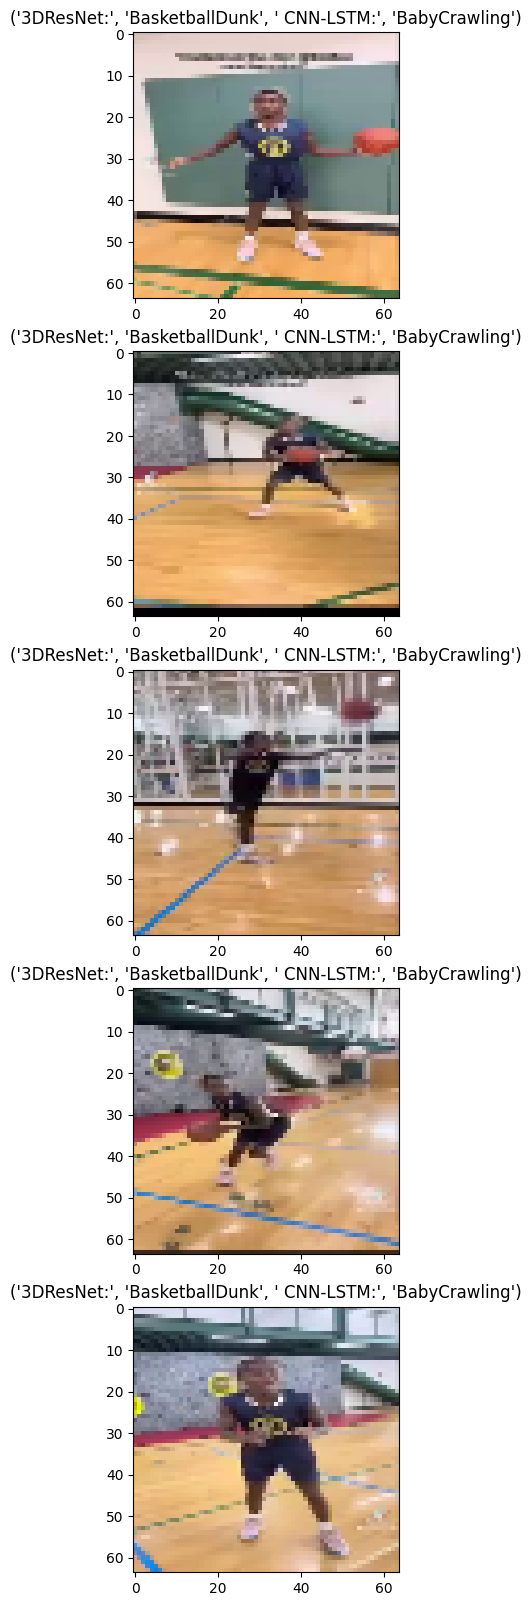

In [22]:
eval_real('/kaggle/input/real-videos1/The first person to ever dribble  (144p).avi')